In [26]:
import tkinter as tk
from tkinter import *
from tkinter import messagebox
from tkinter import ttk
from PIL import ImageTk, Image
import numpy as np
import random
import time
import math
import matplotlib.pyplot as plt

In [16]:
from IPython.display import clear_output

In [17]:
class Car:
    def __init__(self, length, x, y, vx, vy, ax, ay, dir, status, maxv, maxa):
        self.length = length
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.ax = ax
        self.ay = ay
        self.dir = dir
        self.gui = None
        self.max_a =maxa
        self.max_v = maxv
        self.status = status
        
    def update_pos(self, dt):
        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
        self.vx = self.vx + self.ax*dt
        self.vy = self.vy + self.ay*dt
        
    def update(self, dt, light, yellowTime, int_x, int_y, prevcar, followTime, stopDistance):
        self.status = "accelerating"
        if (prevcar != None):
            self.car_response(prevcar, dt, light, followTime, stopDistance)
        self.light_response(dt, light, yellowTime, int_x, int_y)

        if (self.status == "accelerating" or self.status == "going_on_yellow"):
            if (self.dir == 'x'):
                self.ax = self.max_a
                if (abs(self.vx + self.ax*dt) >= self.max_v):
                    self.ax = 0
                    self.vx = self.max_v
                    status = "cruising"
                    
            elif (self.dir == 'y'):
                self.ay = self.max_a
                if (abs(self.vy + self.ay*dt) >= self.max_v):
                    self.ay = 0
                    self.vy = self.max_v
                    status = "cruising"
        else:
            if (self.dir == 'x'):
                self.ax = -self.max_a
            elif (self.dir == 'y'):
                self.ay = -self.max_a

        if ((self.vx + self.ax*dt) < 0):
            self.vx = 0
            self.ax = 0
            if (self.status == "braking_for_light"):
                self.status = "stopped_for_light"
            elif (self.status == "braking_for_car"):
                self.status = "stopped_for_car"
        if ((self.vy + self.ay*dt) < 0):
            self.vy = 0
            self.ay = 0
            if (self.status == "braking_for_light"):
                self.status = "stopped_for_light"
            elif (self.status == "braking_for_car"):
                self.status = "stopped_for_car"

        
        
        self.update_pos(dt)

    def car_response(self, car, dt, light, followTime, stopDistance):
        if (self.dir == 'x'):
            if ((self.vx < car.vx and car.x - car.length - self.x < stopDistance) or time_dist(car.x - car.length, self.x + (car.vx**2 - self.vx**2) / (2 * -self.max_a) + stopDistance, car.vx) < followTime):
                self.status = "braking_for_car"
        elif (self.dir == 'y'):
            if ((self.vy < car.vy and car.y - car.length - self.y < stopDistance) or time_dist(car.y - car.length, self.y + (car.vy**2 - self.vy**2) / (2 * -self.max_a) + stopDistance, car.vy) < followTime):
                self.status = "braking_for_car"
        

    def light_response(self, dt, light, yellowTime, int_x, int_y):
        if (self.dir == 'x'):
            v = self.vx
            s = self.x
            i = int_x[0]
        elif (self.dir == 'y'):
            v = self.vy
            s = self.y
            i = int_y[0]
        if (light != self.dir and s <= i and self.status != "stopped_for_light" and self.status != "going_on_yellow"):
            if (s + self.get_stopping_dist() > i):
                self.status = "going_on_yellow"
            elif (s + self.get_stopping_dist() > i - 2*self.max_v*dt):
                self.status = "braking_for_light"

    def get_stopping_dist(self):
        if (self.dir == 'x'):
            v = self.vx
            s = self.x
        elif (self.dir == 'y'):
            v = self.vy
            s = self.y

        return v**2/(2*self.max_a)


def time_dist(x1, x2, v):
    if (v == 0):
        if (x1 > x2):
            return np.inf
        return 0
    return (x1 - x2) / v
        
def update_car(cv, dt, light, yellowTime, int_x, int_y, car, prevcar, followTime, stopDistance):
    try: cv.delete(car.gui)
    except: pass

    car.update(dt, light, yellowTime, int_x, int_y, prevcar, followTime, stopDistance)
    if (car.dir == 'x'):
        car.gui = cv.create_line(car.x-car.length,car.y,car.x,car.y)
    elif (car.dir == 'y'):
        car.gui = cv.create_line(car.x,car.y-car.length,car.x,car.y)

def run_simulation(U, T=10000, carLength=10, height=1000, width=1000, xrate=.05, yrate=.05, dt = .01, random_speeds = False, quit_on_end=False, lightTime=10, yellowTime=3, followTime=.2, stopDistance=10, maxv=10, maxa=4, stats = True):
    arrivals = 0
    x_count = 0
    y_count = 0
    t = 0
    int_x=(int(width*.48),int(width*.52))
    int_y=(int(height*.48),int(height*.52))
    
    try:        
        root = Tk()
        root.title("Traffic Simulation")
        cv = Canvas(root,height=height, width=width)
        cv.pack()
    
        imgHeight = int(height*.1)
        imgWidth = int(height*.04)
    
        redlight = ImageTk.PhotoImage(Image.open("redlight.png").resize((imgWidth, imgHeight)))
        yellowlight = ImageTk.PhotoImage(Image.open("yellowlight.png").resize((imgWidth, imgHeight)))
        greenlight = ImageTk.PhotoImage(Image.open("greenlight.png").resize((imgWidth, imgHeight)))
    
        light = 'x'
        
        xlight = Label(root, image = greenlight)
        xlight.place(x=width-imgWidth, y=height/2)
        ylight = Label(root, image = redlight)
        ylight.place(x=width/2, y=height-imgHeight)
        
        xcars = []
        ycars = []
        i = 0
        for t in range(T):
            if (U[i] < xrate):
                if random_speeds:
                    newCar = Car(carLength,0,width/2,(random.random()+1)/2,0,0,0,'x',"cruising", maxv)
                else:
                    newCar = Car(carLength,0,width/2,1,0,0,0,'x',"cruising", maxv=maxv, maxa=maxa)
                xcars.append(newCar)
                arrivals += 1
            elif (U[i] < xrate + yrate):
                if random_speeds:
                    newCar = Car(carLength,0,height/2,(random.random()+1)/2,0,0,0,'x',"cruising", maxv)
                else:
                    newCar = Car(carLength,height/2,0,0,1,0,0,'y',"cruising", maxv=maxv, maxa=maxa)
                ycars.append(newCar)
                arrivals +=1
            i += 1
    
            try:
                if (xcars[0].x-xcars[0].length>width):
                    cv.delete(xcars[0].gui)
                    xcars.pop(0)
                    x_count += 1
                else:
                    update_car(cv, dt, light, yellowTime, int_x, int_y, xcars[0], None, followTime, stopDistance)
                prevcar = xcars[0]
            except:
                prevcar = None
            
            if (len(xcars) > 1):
                for car in xcars[1:]:
                    update_car(cv, dt, light, yellowTime, int_x, int_y, car, prevcar, followTime, stopDistance)
                    prevcar = car
    
            try:
                if (ycars[0].y-ycars[0].length>height):
                    cv.delete(ycars[0].gui)
                    ycars.pop(0)
                    y_count += 1
                else:
                    update_car(cv, dt, light, yellowTime, int_x, int_y, ycars[0], None, followTime, stopDistance)
                prevcar = ycars[0]
            except:
                prevcar = None
    
            if (len(ycars) > 1):
                for car in ycars[1:]:
                    update_car(cv, dt, light, yellowTime, int_x, int_y, car, prevcar, followTime, stopDistance)
                    prevcar = car
                #print(ycars[0].status, ycars[0].y, ycars[0].vy, ycars[0].get_stopping_dist())
    
    
            xflow = x_count / ((t+1)*dt)
            yflow = y_count / ((t+1)*dt)

            if stats:

                countlabel = Label(root, text=f"xcars={x_count} ycars={y_count}", fg="black")
                flowlabel = Label(root, text=f"xcars/s={xflow: .2f} ycars/s={yflow: .2f}", fg="black")
                timelabel = Label(root, text=f"sec={t*dt: .2f}", fg="black")
    
                countlabel.place(x=5, y=0)
                flowlabel.place(x=5, y=20)
                timelabel.place(x=5, y=40)
                    
            root.update()
            root.after(int(dt*100))

            if stats:
                countlabel.destroy()
                flowlabel.destroy()
                timelabel.destroy()

            
    
            if (t % int(100*lightTime) == 100*lightTime - 100*yellowTime - 1):
                if (light == 'x'):
                    light = 'xy'
                    xlight.destroy()
                    xlight = Label(root, image = yellowlight)
                    xlight.place(x=width-imgWidth, y=height / 2)
                else:
                    light = 'yx'
                    ylight.destroy()
                    ylight = Label(root, image = yellowlight)
                    ylight.place(x=width/2, y=height-imgHeight)
            elif (t % int(100*lightTime) == 100*lightTime - 1):
                if (light == 'xy'):
                    light = 'y'
                    xlight.destroy()
                    xlight = Label(root, image = redlight)
                    xlight.place(x=width-imgWidth, y=height / 2)
                    ylight.destroy()
                    ylight = Label(root, image = greenlight)
                    ylight.place(x=width/2, y=height-imgHeight)
                else:
                    light = 'x'
                    xlight.destroy()
                    xlight = Label(root, image = greenlight)
                    xlight.place(x=width-imgWidth, y=height / 2)
                    ylight.destroy()
                    ylight = Label(root, image = redlight)
                    ylight.place(x=width/2, y=height-imgHeight)
    
            
    
            
    
    
            if (t % 10 == 0):
                clear_output()

        root.destroy()
        return (arrivals, x_count, y_count, t*dt)    
    
    except:
        return (arrivals, x_count, y_count, t*dt)
        root.destroy()

In [18]:
# Generate N interarrival times

N = 100000
U = np.random.uniform(0, 1, N)
V = 1 - U

In [19]:
# Run the simulation with parameters
# Set stats parameter to true to see real-time flow rates, but simulation runs faster when set to false
# Returns xcount, ycount, elapsed simulation time in seconds (simulation time may not equal real time)

run_simulation(U, T=100000, height=500, width = 500, xrate=.005,yrate=.005, yellowTime = 2, lightTime=10, followTime=.2, stopDistance=10, maxv=200, maxa=100, stats = False)

(8, 2, 0, 6.01)

In [24]:
replications = 10
xflow1 = []
xflow2 = []

for i in range(replications):
    N = 100000
    U = np.random.uniform(0, 1, N)
    V = 1 - U
    xflow1.append(run_simulation(U, T=1000, height=500, width = 500, xrate=.01,yrate=.01, yellowTime = 1, lightTime=5, followTime=.2, stopDistance=10, maxv=2000, maxa=1000, stats = False)[1])
    xflow2.append(run_simulation(V, T=1000, height=500, width = 500, xrate=.01,yrate=.01, yellowTime = 1, lightTime=5, followTime=.2, stopDistance=10, maxv=2000, maxa=1000, stats = False)[1])

print(xflow1)
print(xflow2)

[3, 5]
[3, 5]


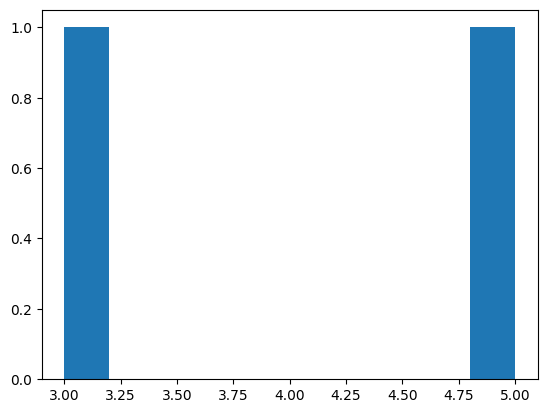

In [28]:
# Plot histogram

plt.hist(xflow1)
plt.show() 

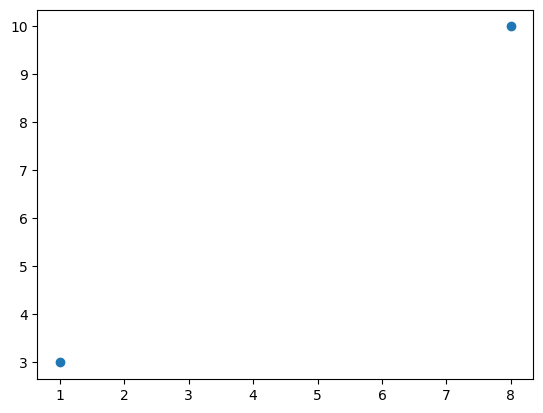

In [29]:
# Create x-y plot

xpoints = np.array([1, 8])
ypoints = np.array([3, 10])

plt.plot(xpoints, ypoints, 'o')
plt.show()

In [10]:
# Runs the simulation for a short period 8 times, tracks number of total arrivals

arrivals = []
for i in range(8):
    N = 100000
    U = np.random.uniform(0, 1, N)
    arrivals.append(run_simulation(U, T=1000, height=500, width = 500, xrate=.005,yrate=.005, yellowTime = 2, lightTime = 5, followTime=.2, stopDistance=10, maxv=200, maxa=100, stats = False)[0])

print(arrivals)

[14, 9, 13, 19, 7, 11, 11, 14]


In [11]:
# Generates arrivals according to Poisson process using inverse transform method, for comparison

arrivals = []
rate = .010
T = 1000

for j in range(8):
    input = random.random()
    cum_func = 0
    i = 0
    while (cum_func < input):
        dens_func = ((rate*T)**i)*math.exp(-rate*T)/math.factorial(i)
        cum_func += dens_func
        i += 1
    arrivals.append(i)

print(arrivals)

[9, 7, 10, 5, 12, 8, 8, 13]
